In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
np.set_printoptions(linewidth=np.inf)
import sympy as sp
import scipy as sc
from scipy import integrate,signal,stats,io
from sklearn.linear_model import Lasso,ridge_regression
from sklearn.utils.extmath import weighted_mode

from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline

import pysindy as ps

from tqdm import tqdm,tnrange

import copy

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

C:\Users\rautj\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\rautj\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\rautj\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


In [3]:
from sindy_functions import *
from systems import *

In [4]:
def HAVOK(X,dt,mo,r=0,get_lmodel=False):
    
    """
    Basic HAVOK algorithm
    
    Input: 
    Output: 
    """
    
    if r==0:
        r=mo*X.shape[0]
    
    H=X[:,0:0-mo]
    for k in range(1,mo):
        H=np.vstack((H,X[:,k:k-mo]))
    
    U,s,Vt=np.linalg.svd(H,full_matrices=False)
    V=Vt.T
    #S=np.diag(s)
    
    returns=[U,s,V]
    
    if get_lmodel:
        
        dV=np.zeros((V.shape[0]-5,r))
        for i in range(2,V.shape[0]-3):
            for k in range(r):
                dV[i-2,k] = (1/(12*dt))*(-V[i+2,k]+8*V[i+1,k]-8*V[i-1,k]+V[i-2,k])

        Vr=V[2:-3,0:r]

        Xi=np.linalg.lstsq(Vr,dV,rcond=None)[0]
        A = Xi[0:r-1,0:r-1].T
        B = Xi[-1,0:r-1].reshape(-1,1)
        
        returns.append(A)
        returns.append(B)
    
    return returns

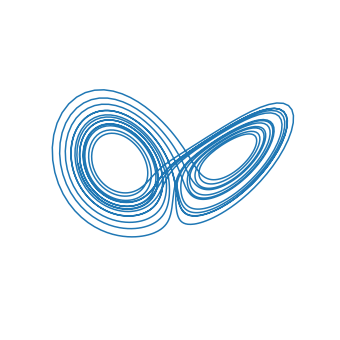

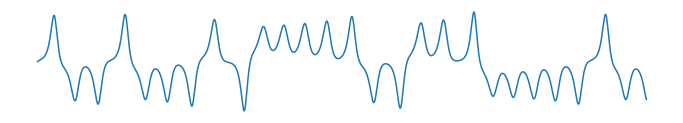

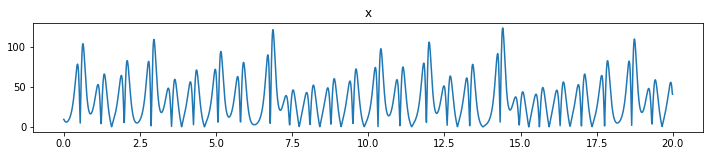

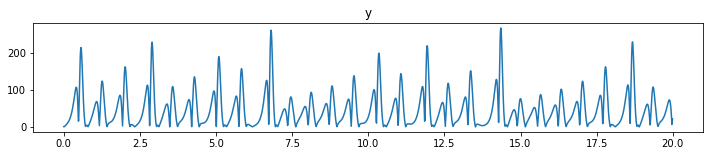

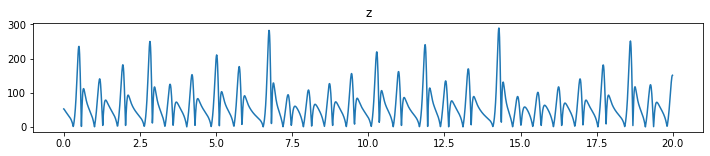

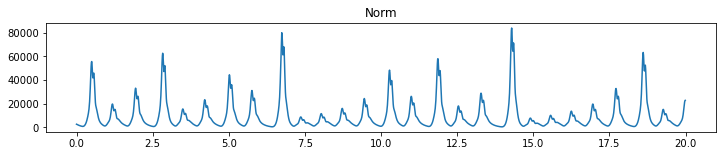

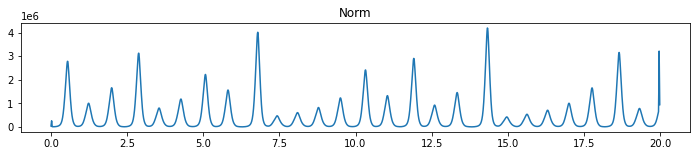

In [5]:
x0=[0,1,20]

dt=0.01
tstamps=np.arange(0,20,dt)

Sol=sc.integrate.odeint(lorenz,x0,tstamps,args=(),rtol=1e-12,atol=1e-12).T
Soldt=np.gradient(Sol.T[:,:],dt,axis=0).T

plt.figure(figsize=(8,6))
ax=plt.axes(projection='3d')
ax.plot3D(Sol[0], Sol[1], Sol[2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.axis('off')
plt.show()

plt.figure(figsize=(12, 2))
plt.plot(Sol[0])
plt.xlabel('element')
plt.ylabel('value')
plt.axis('off')
plt.show()

plt.figure(figsize=(12,2))
plt.title('x')
plt.plot(tstamps,np.abs(np.gradient(Sol[0],dt)))
plt.show()

plt.figure(figsize=(12,2))
plt.title('y')
plt.plot(tstamps,np.abs(np.gradient(Sol[1],dt)))
plt.show()

plt.figure(figsize=(12,2))
plt.title('z')
plt.plot(tstamps,np.abs(np.gradient(Sol[2],dt)))
plt.show()

plt.figure(figsize=(12,2))
plt.title('Norm')
plt.plot(tstamps,np.linalg.norm(np.gradient(Sol,dt,axis=1)**2,axis=0))
plt.show()

plt.figure(figsize=(12,2))
plt.title('Norm')
plt.plot(tstamps,np.linalg.norm(np.gradient(np.gradient(np.gradient(np.gradient(Sol,dt,axis=1),dt,axis=1),dt,axis=1),dt,axis=1),axis=0))
plt.show()

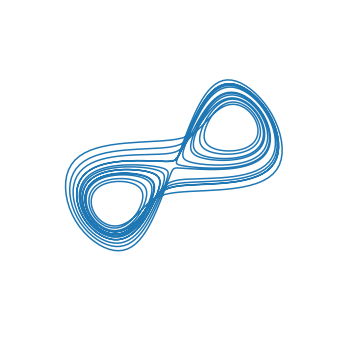

In [6]:
nlag=10

plt.figure(figsize=(8,6))
ax=plt.axes(projection='3d')
ax.plot3D(Sol[0][:-2*nlag], Sol[0][nlag:-nlag], Sol[0][2*nlag:])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.axis('off')
plt.show()

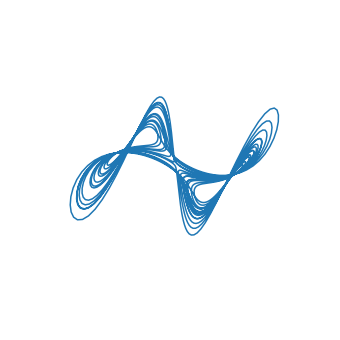

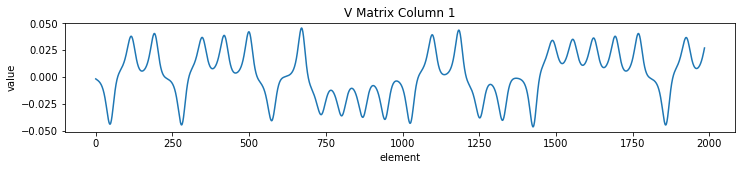

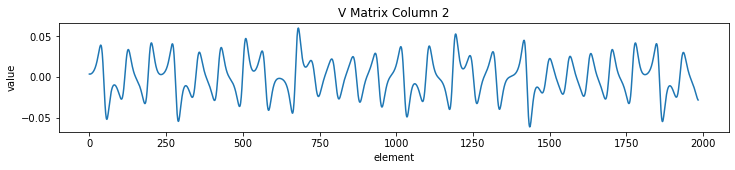

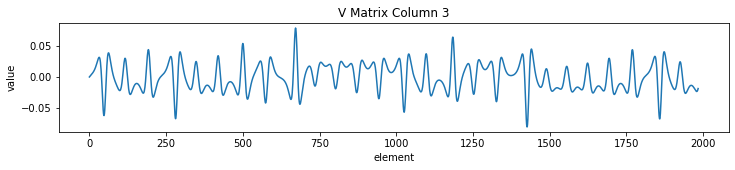

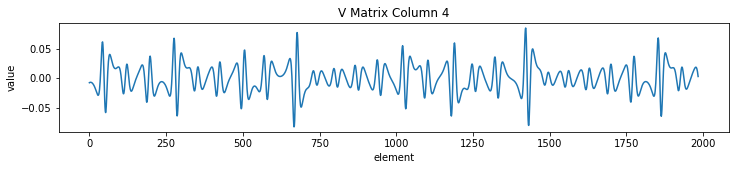

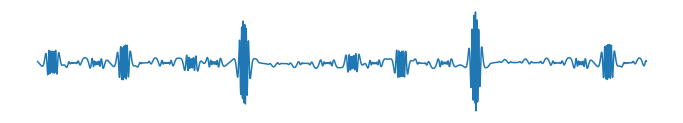

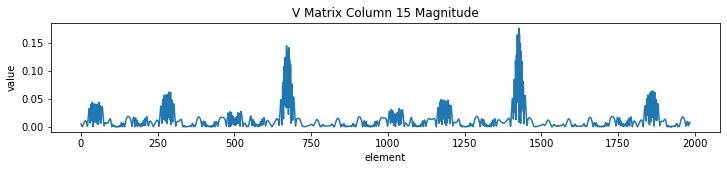

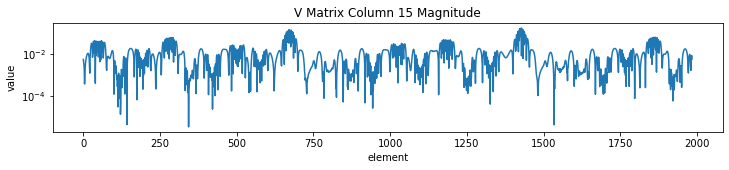

In [7]:
U,s,V,A,B=HAVOK(Sol[0].reshape(1,-1),dt,15,get_lmodel=True)

plt.figure(figsize=(8,6))
ax=plt.axes(projection='3d')
ax.plot3D(V[:,0], V[:,1], V[:,2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.axis('off')
plt.show()

for i in range(4):
    plt.figure(figsize=(12, 2))
    plt.title('V Matrix Column '+str(i+1))
    plt.plot(range(len(V[:,i])),V[:,i])
    plt.xlabel('element')
    plt.ylabel('value')
    plt.show()

i=U.shape[0]-1
plt.figure(figsize=(12, 2))
#plt.title('V Matrix Column '+str(i+1))
plt.plot(range(len(V[:,i])),V[:,i])
plt.xlabel('element')
plt.ylabel('value')
plt.axis('off')
plt.show()

i=U.shape[0]-1
plt.figure(figsize=(12, 2))
plt.title('V Matrix Column '+str(i+1)+' Magnitude')
plt.plot(range(len(V[:,i])),np.abs(V[:,i]))
plt.xlabel('element')
plt.ylabel('value')
plt.show()

i=U.shape[0]-1
plt.figure(figsize=(12, 2))
plt.title('V Matrix Column '+str(i+1)+' Magnitude')
plt.plot(range(len(V[:,i])),np.abs(V[:,i]))
plt.xlabel('element')
plt.ylabel('value')
plt.yscale('log')
plt.show()

In [8]:
vmin=np.min([np.min(A),np.min(B)])
vmax=np.max([np.max(A),np.max(B)])
print(vmin,vmax)

-59.25323035770326 64.5499654690594


In [9]:
vmin,vmax==-np.max(np.abs([vmin,vmax])),np.max(np.abs([vmin,vmax]))
print(vmin,vmax)

-59.25323035770326 64.5499654690594


In [10]:
A.shape

(14, 14)

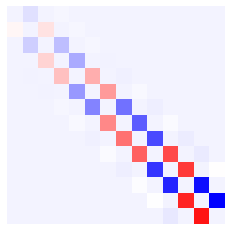

In [11]:
plt.figure()
plt.imshow(A,cmap='bwr',vmin=vmin,vmax=vmax)
plt.axis('off')
plt.show()

In [12]:
B.shape

(14, 1)

In [13]:
plt.figure()
plt.imshow(B,cmap='bwr',vmin=vmin,vmax=vmax)
plt.axis('off')
plt.show()

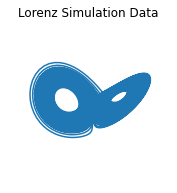

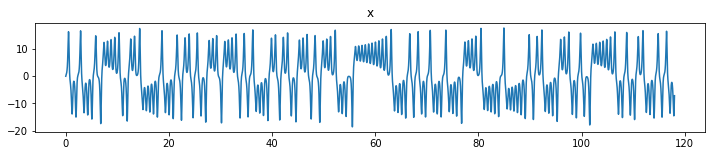

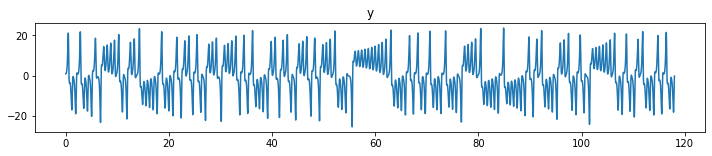

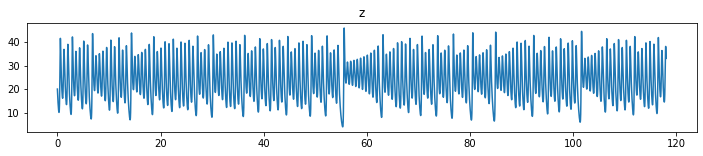

In [14]:
x0=[0,1,20]

dt=0.01
tstamps=np.arange(0,118,dt)

Sol=sc.integrate.odeint(lorenz,x0,tstamps,args=(),rtol=1e-12,atol=1e-12).T
Soldt=np.gradient(Sol.T[:,:],dt,axis=0).T

plt.figure(figsize=(4,3))
ax=plt.axes(projection='3d')
ax.plot3D(Sol[0], Sol[1], Sol[2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.title('Lorenz Simulation Data')
plt.axis('off')
plt.show()

plt.figure(figsize=(12,2))
plt.title('x')
plt.plot(tstamps,Sol[0])
plt.show()

plt.figure(figsize=(12,2))
plt.title('y')
plt.plot(tstamps,Sol[1])
plt.show()

plt.figure(figsize=(12,2))
plt.title('z')
plt.plot(tstamps,Sol[2])
plt.show()

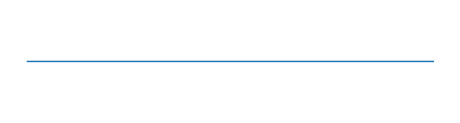

In [15]:
plt.figure(figsize=(8,2))
plt.plot(tstamps,0*(np.gradient(Sol[0],dt)-lorenz(Sol,tstamps)[0])**2)
plt.axis('off')
plt.show()

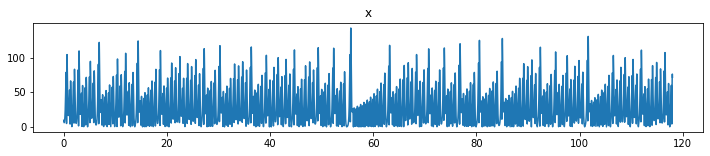

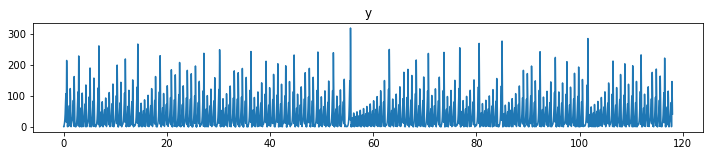

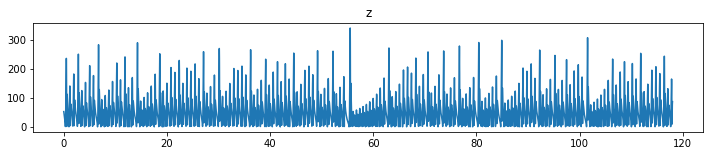

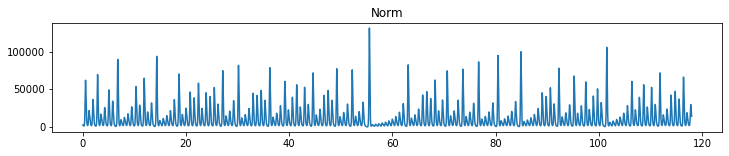

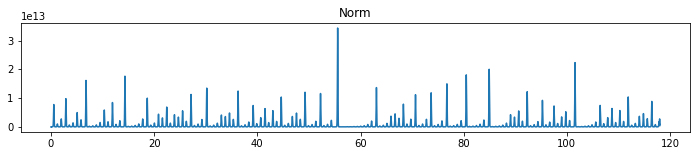

In [16]:
plt.figure(figsize=(12,2))
plt.title('x')
plt.plot(tstamps,np.abs(np.gradient(Sol[0],dt)))
plt.show()

plt.figure(figsize=(12,2))
plt.title('y')
plt.plot(tstamps,np.abs(np.gradient(Sol[1],dt)))
plt.show()

plt.figure(figsize=(12,2))
plt.title('z')
plt.plot(tstamps,np.abs(np.gradient(Sol[2],dt)))
plt.show()

plt.figure(figsize=(12,2))
plt.title('Norm')
plt.plot(tstamps,np.linalg.norm(np.gradient(Sol,dt,axis=1),axis=0)**2)
plt.show()

plt.figure(figsize=(12,2))
plt.title('Norm')
plt.plot(tstamps,np.linalg.norm(np.gradient(np.gradient(np.gradient(np.gradient(Sol,dt,axis=1),dt,axis=1),dt,axis=1),dt,axis=1),axis=0)**2)
plt.show()

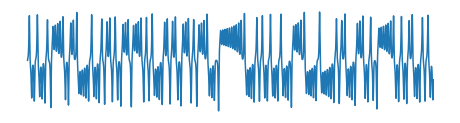

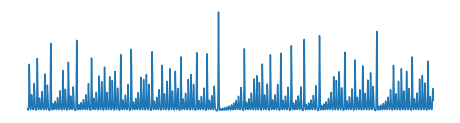

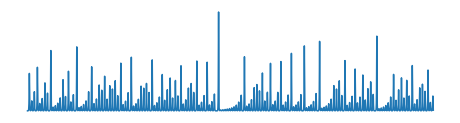

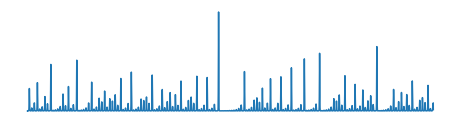

In [17]:
plt.figure(figsize=(8,2))
plt.plot(tstamps,Sol[0])
plt.axis('off')
plt.show()

plt.figure(figsize=(8,2))
plt.plot(tstamps,np.linalg.norm(np.gradient(Sol,dt,axis=1),axis=0)**2)
plt.axis('off')
plt.show()

plt.figure(figsize=(8,2))
plt.plot(tstamps,np.linalg.norm(np.gradient(np.gradient(Sol,dt,axis=1),dt,axis=1),axis=0)**2)
plt.axis('off')
plt.show()

plt.figure(figsize=(8,2))
plt.plot(tstamps,np.linalg.norm(np.gradient(np.gradient(np.gradient(np.gradient(Sol,dt,axis=1),dt,axis=1),dt,axis=1),dt,axis=1),axis=0)**2)
plt.axis('off')
plt.show()

In [18]:
deg=5
thres=0.1
model = ps.SINDy(feature_names=["x","y","z"],optimizer=ps.STLSQ(threshold=thres),feature_library=ps.PolynomialLibrary(degree=deg))
model.fit(Sol[:,:].T, t=tstamps[:])
model.print()
#print()
mc=model.coefficients()

(x)' = -9.978 x + 9.978 y
(y)' = 27.800 x + -0.961 y + -0.994 x z
(z)' = -2.659 z + 0.997 x y


C:\Users\rautj\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.56672e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\rautj\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.56672e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\rautj\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.56672e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


In [19]:
thres=0.1
nc=np.abs(Sol.T).max(axis=0)
lsw=(10**-np.average(np.log10(1/nc/min(1/nc))))/nc/min(1/nc)
mc=SINDy(polypool(Sol[:,:].T,deg),np.gradient(Sol[:,:],dt,axis=1).T,thres,reg=0,normalise=polypool((1e-0*lsw).reshape(1,-1),deg).tolist()[0])
mc=mc.T
model.coefficients()[:,:]=mc
model.print()

(x)' = -9.978 x + 9.978 y
(y)' = 27.800 x + -0.961 y + -0.994 x z
(z)' = -49.518 1 + -0.527 x^2 + 1.317 x y


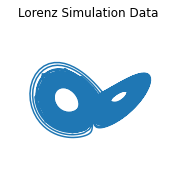

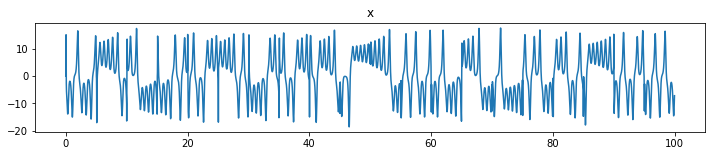

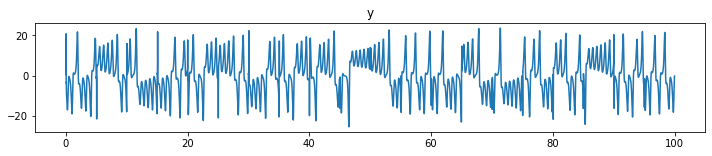

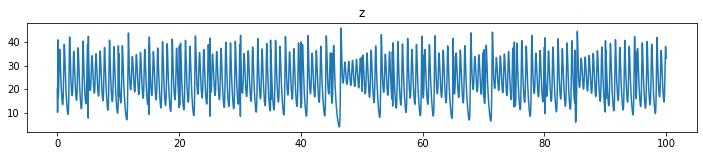

In [20]:
x0=[0,1,20]

dt=0.01
tstamps=np.arange(0,118,dt)

Sol=sc.integrate.odeint(lorenz,x0,tstamps,args=(),rtol=1e-12,atol=1e-12).T
Soldt=np.gradient(Sol.T[:,:],dt,axis=0).T

'''ind=np.arange(int(1/dt))
ind=np.delete(ind,np.arange(int(1/dt))[::10],0)
indt=np.copy(ind)
for i in range(20):
    indt=np.append(indt,i*600+ind)
    
Sol=np.delete(Sol.T,indt,0).T
tstamps=np.arange(0,100,dt)'''

at=10

ind=np.arange(500-at)+100
ind=np.append(np.arange(at)*10,ind)
indt=np.copy(ind)
for i in range(1,20):
    indt=np.append(indt,i*(600-at)+ind)
    
Sol=Sol.T[indt].T
tstamps=np.arange(0,100,dt)

plt.figure(figsize=(4,3))
ax=plt.axes(projection='3d')
ax.plot3D(Sol[0], Sol[1], Sol[2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.title('Lorenz Simulation Data')
plt.axis('off')
plt.show()

plt.figure(figsize=(12,2))
plt.title('x')
plt.plot(tstamps,Sol[0])
plt.show()

plt.figure(figsize=(12,2))
plt.title('y')
plt.plot(tstamps,Sol[1])
plt.show()

plt.figure(figsize=(12,2))
plt.title('z')
plt.plot(tstamps,Sol[2])
plt.show()

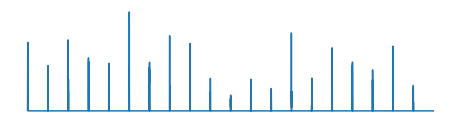

In [21]:
plt.figure(figsize=(8,2))
plt.plot(tstamps,(np.gradient(Sol[0],dt)-lorenz(Sol,tstamps)[0])**2)
plt.axis('off')
plt.show()

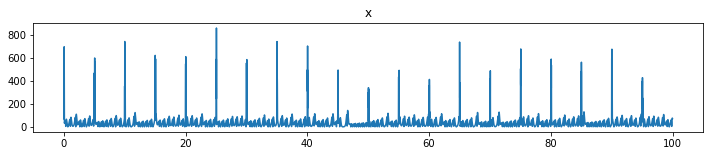

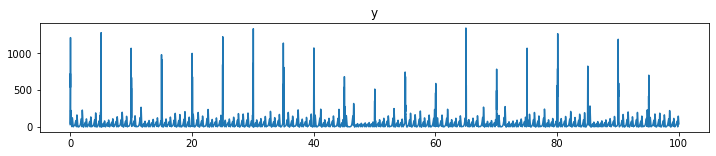

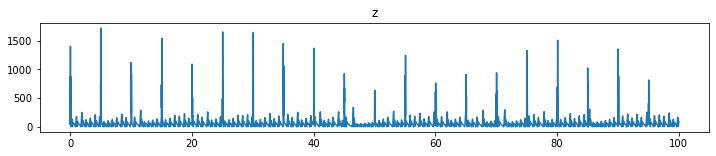

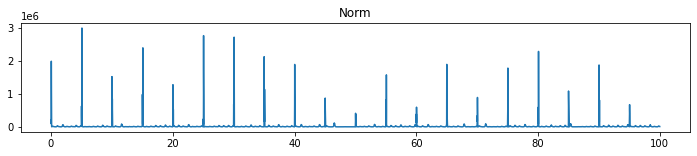

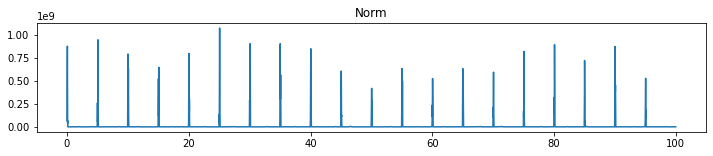

In [22]:
plt.figure(figsize=(12,2))
plt.title('x')
plt.plot(tstamps,np.abs(np.gradient(Sol[0],dt)))
plt.show()

plt.figure(figsize=(12,2))
plt.title('y')
plt.plot(tstamps,np.abs(np.gradient(Sol[1],dt)))
plt.show()

plt.figure(figsize=(12,2))
plt.title('z')
plt.plot(tstamps,np.abs(np.gradient(Sol[2],dt)))
plt.show()

plt.figure(figsize=(12,2))
plt.title('Norm')
plt.plot(tstamps,np.linalg.norm(np.gradient(Sol,dt,axis=1)**2,axis=0))
plt.show()

plt.figure(figsize=(12,2))
plt.title('Norm')
plt.plot(tstamps,np.linalg.norm(np.gradient(np.gradient(np.gradient(np.gradient(Sol,dt,axis=1),dt,axis=1),dt,axis=1),dt,axis=1),axis=0))
plt.show()

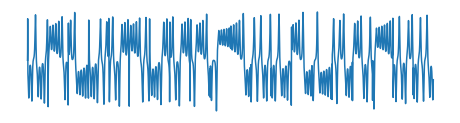

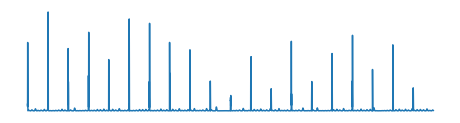

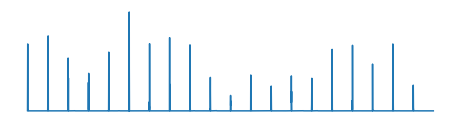

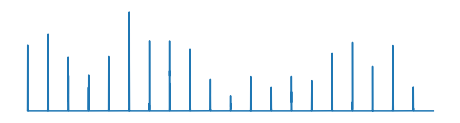

In [23]:
plt.figure(figsize=(8,2))
plt.plot(tstamps,Sol[0])
plt.axis('off')
plt.show()

plt.figure(figsize=(8,2))
plt.plot(tstamps,np.linalg.norm(np.gradient(Sol,dt,axis=1),axis=0)**2)
plt.axis('off')
plt.show()

plt.figure(figsize=(8,2))
plt.plot(tstamps,np.linalg.norm(np.gradient(np.gradient(Sol,dt,axis=1),dt,axis=1),axis=0)**2)
plt.axis('off')
plt.show()

plt.figure(figsize=(8,2))
plt.plot(tstamps,np.linalg.norm(np.gradient(np.gradient(np.gradient(np.gradient(Sol,dt,axis=1),dt,axis=1),dt,axis=1),dt,axis=1),axis=0)**2)
plt.axis('off')
plt.show()

In [24]:
thres=0.1
nc=np.abs(Sol.T).max(axis=0)
lsw=(10**-np.average(np.log10(1/nc/min(1/nc))))/nc/min(1/nc)
mc=SINDy(polypool(Sol[:,:].T,deg),np.gradient(Sol[:,:],dt,axis=1).T,thres,reg=0,normalise=polypool((1e-0*lsw).reshape(1,-1),deg).tolist()[0])
mc=mc.T
model.coefficients()[:,:]=mc
model.print()

(x)' = -4.235 1 + -11.520 x + 11.521 y + 0.205 z
(y)' = -7.873 1 + 30.384 x + -0.621 y + 0.366 z + -1.108 x z
(z)' = 8.054 1 + 0.475 x + -0.654 y + -3.596 z + 0.243 x^2 + 0.810 x y + 0.131 y^2


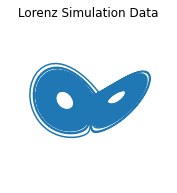

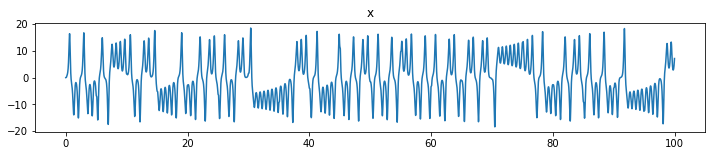

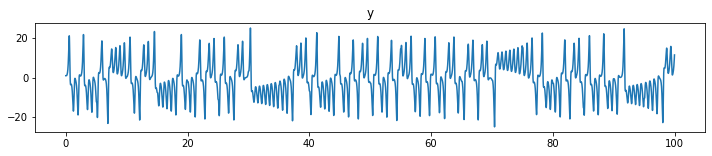

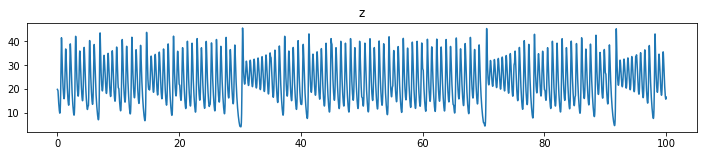

In [25]:
x0=[0,1,20]

dt=0.001
tstamps=np.arange(0,100,dt)

Sol=sc.integrate.odeint(lorenz,x0,tstamps,args=(),rtol=1e-12,atol=1e-12).T
Soldt=np.gradient(Sol.T[:,:],dt,axis=0).T

at=10

ind=np.arange(500-at)*10+at
ind=np.append(np.arange(at),ind)
indt=np.copy(ind)
for i in range(1,20):
    indt=np.append(indt,i*(10*(500-at)+1)+ind)
    
dt=0.01
Sol=Sol.T[indt].T
tstamps=np.arange(0,100,dt)

plt.figure(figsize=(4,3))
ax=plt.axes(projection='3d')
ax.plot3D(Sol[0], Sol[1], Sol[2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.title('Lorenz Simulation Data')
plt.axis('off')
plt.show()

plt.figure(figsize=(12,2))
plt.title('x')
plt.plot(tstamps,Sol[0])
plt.show()

plt.figure(figsize=(12,2))
plt.title('y')
plt.plot(tstamps,Sol[1])
plt.show()

plt.figure(figsize=(12,2))
plt.title('z')
plt.plot(tstamps,Sol[2])
plt.show()

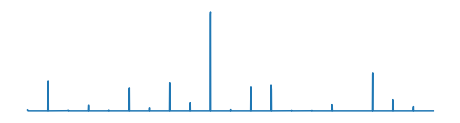

In [26]:
plt.figure(figsize=(8,2))
plt.plot(tstamps,(np.gradient(Sol[0],dt)-lorenz(Sol,tstamps)[0])**2)
plt.axis('off')
plt.show()

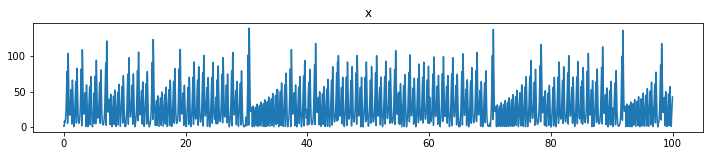

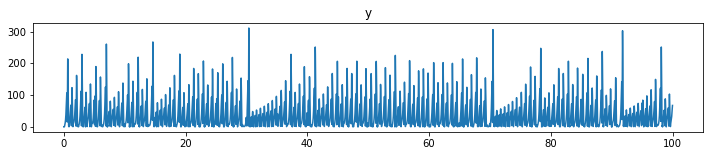

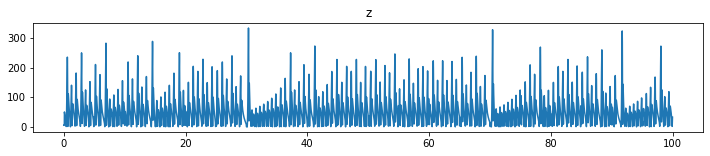

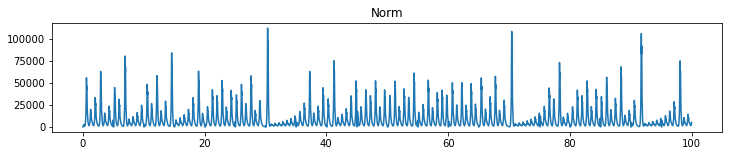

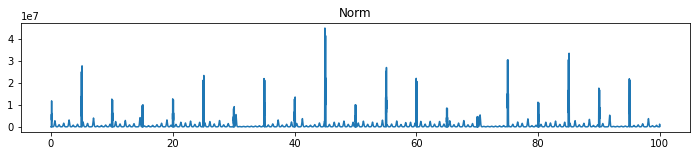

In [27]:
plt.figure(figsize=(12,2))
plt.title('x')
plt.plot(tstamps,np.abs(np.gradient(Sol[0],dt)))
plt.show()

plt.figure(figsize=(12,2))
plt.title('y')
plt.plot(tstamps,np.abs(np.gradient(Sol[1],dt)))
plt.show()

plt.figure(figsize=(12,2))
plt.title('z')
plt.plot(tstamps,np.abs(np.gradient(Sol[2],dt)))
plt.show()

plt.figure(figsize=(12,2))
plt.title('Norm')
plt.plot(tstamps,np.linalg.norm(np.gradient(Sol,dt,axis=1)**2,axis=0))
plt.show()

plt.figure(figsize=(12,2))
plt.title('Norm')
plt.plot(tstamps,np.linalg.norm(np.gradient(np.gradient(np.gradient(np.gradient(Sol,dt,axis=1),dt,axis=1),dt,axis=1),dt,axis=1),axis=0))
plt.show()

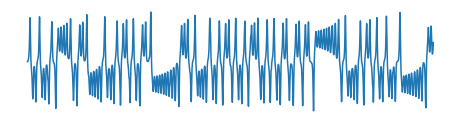

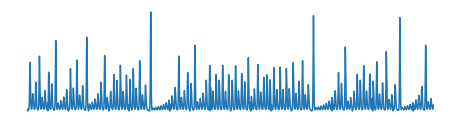

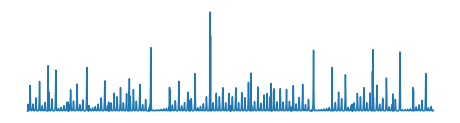

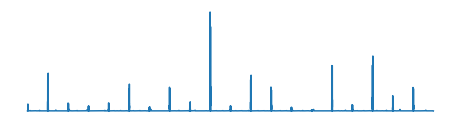

In [28]:
plt.figure(figsize=(8,2))
plt.plot(tstamps,Sol[0])
plt.axis('off')
plt.show()

plt.figure(figsize=(8,2))
plt.plot(tstamps,np.linalg.norm(np.gradient(Sol,dt,axis=1),axis=0)**2)
plt.axis('off')
plt.show()

plt.figure(figsize=(8,2))
plt.plot(tstamps,np.linalg.norm(np.gradient(np.gradient(Sol,dt,axis=1),dt,axis=1),axis=0)**2)
plt.axis('off')
plt.show()

plt.figure(figsize=(8,2))
plt.plot(tstamps,np.linalg.norm(np.gradient(np.gradient(np.gradient(np.gradient(Sol,dt,axis=1),dt,axis=1),dt,axis=1),dt,axis=1),axis=0)**2)
plt.axis('off')
plt.show()

In [29]:
thres=0.1
nc=np.abs(Sol.T).max(axis=0)
lsw=(10**-np.average(np.log10(1/nc/min(1/nc))))/nc/min(1/nc)
mc=SINDy(polypool(Sol[:,:].T,deg),np.gradient(Sol[:,:],dt,axis=1).T,thres,reg=0,normalise=polypool((1e-0*lsw).reshape(1,-1),deg).tolist()[0])
mc=mc.T
model.coefficients()[:,:]=mc
model.print()

(x)' = -9.816 x + 9.813 y
(y)' = 0.336 1 + 27.555 x + -1.030 y + -0.983 x z
(z)' = -0.199 1 + -2.612 z + 0.986 x y


In [30]:
def HAVOK(X,dt,mo,r=0,get_lmodel=False):
    
    """
    Basic HAVOK algorithm
    
    Input: 
    Output: 
    """
    
    if r==0:
        r=mo*X.shape[0]
    
    H=X[:,0:0-mo]
    for k in range(1,mo):
        H=np.vstack((H,X[:,k:k-mo]))
    
    U,s,Vt=np.linalg.svd(H,full_matrices=False)
    V=Vt.T
    #S=np.diag(s)
    
    returns=[U,s,V]
    
    if get_lmodel:
        
        dV=np.zeros((V.shape[0]-5,r))
        for i in range(2,V.shape[0]-3):
            for k in range(r):
                dV[i-2,k] = (1/(12*dt))*(-V[i+2,k]+8*V[i+1,k]-8*V[i-1,k]+V[i-2,k])

        Vr=V[2:-3,0:r]

        Xi=np.linalg.lstsq(Vr,dV,rcond=None)[0]
        A = Xi[0:r-1,0:r-1].T
        B = Xi[-1,0:r-1].reshape(-1,1)
        
        returns.append(A)
        returns.append(B)
    
    return returns

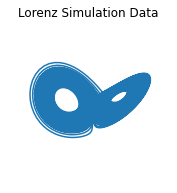

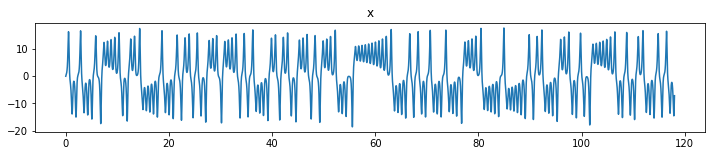

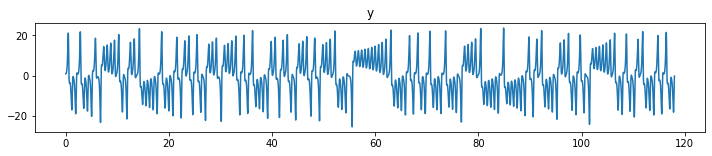

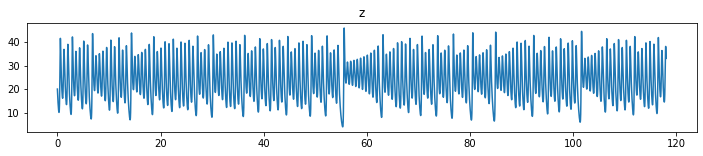

In [31]:
x0=[0,1,20]

dt=0.01
tstamps=np.arange(0,118,dt)

Sol=sc.integrate.odeint(lorenz,x0,tstamps,args=(),rtol=1e-12,atol=1e-12).T
Soldt=np.gradient(Sol.T[:,:],dt,axis=0).T

plt.figure(figsize=(4,3))
ax=plt.axes(projection='3d')
ax.plot3D(Sol[0], Sol[1], Sol[2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.title('Lorenz Simulation Data')
plt.axis('off')
plt.show()

plt.figure(figsize=(12,2))
plt.title('x')
plt.plot(tstamps,Sol[0])
plt.show()

plt.figure(figsize=(12,2))
plt.title('y')
plt.plot(tstamps,Sol[1])
plt.show()

plt.figure(figsize=(12,2))
plt.title('z')
plt.plot(tstamps,Sol[2])
plt.show()

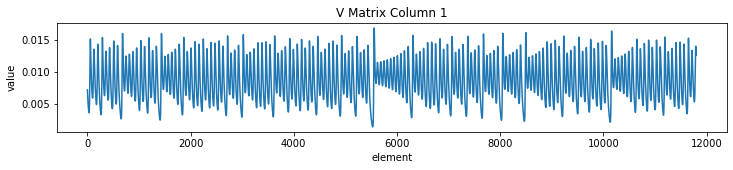

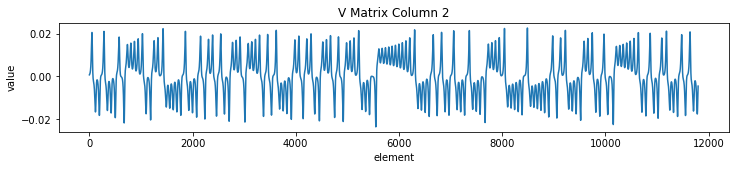

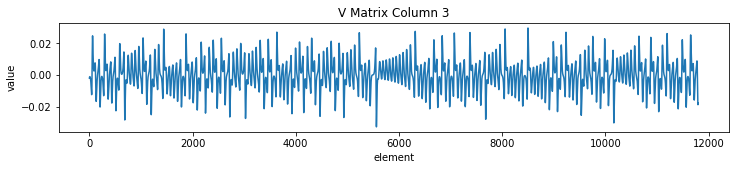

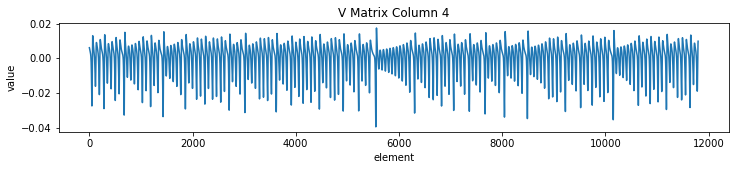

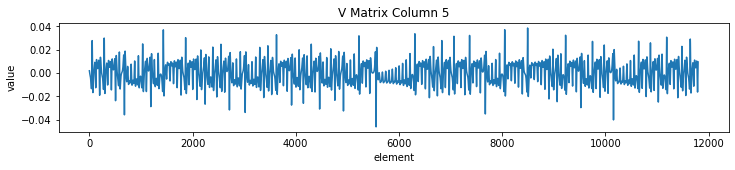

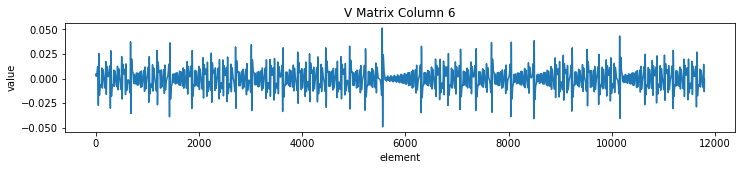

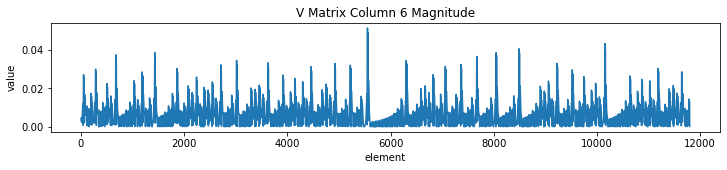

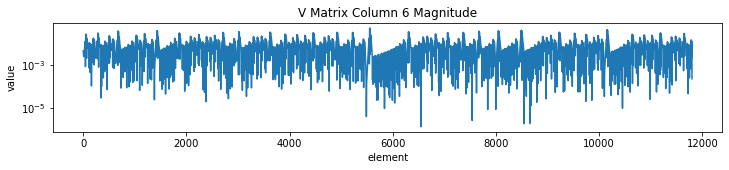

In [32]:
U,s,V,A,B=HAVOK(Sol,dt,2,get_lmodel=True)

for i in range(U.shape[0]):
    plt.figure(figsize=(12, 2))
    plt.title('V Matrix Column '+str(i+1))
    plt.plot(range(len(V[:,i])),V[:,i])
    plt.xlabel('element')
    plt.ylabel('value')
    plt.show()

i=U.shape[0]-1
plt.figure(figsize=(12, 2))
plt.title('V Matrix Column '+str(i+1)+' Magnitude')
plt.plot(range(len(V[:,i])),np.abs(V[:,i]))
plt.xlabel('element')
plt.ylabel('value')
plt.show()

i=U.shape[0]-1
plt.figure(figsize=(12, 2))
plt.title('V Matrix Column '+str(i+1)+' Magnitude')
plt.plot(range(len(V[:,i])),np.abs(V[:,i]))
plt.xlabel('element')
plt.ylabel('value')
plt.yscale('log')
plt.show()

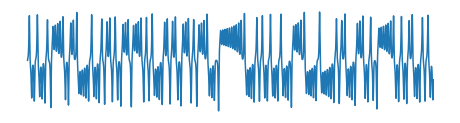

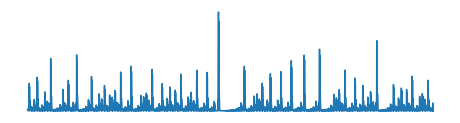

In [33]:
plt.figure(figsize=(8,2))
plt.plot(tstamps,Sol[0])
plt.axis('off')
plt.show()

plt.figure(figsize=(8,2))
plt.plot(range(len(V[:,i])),np.abs(V[:,i])**2)
plt.axis('off')
plt.show()

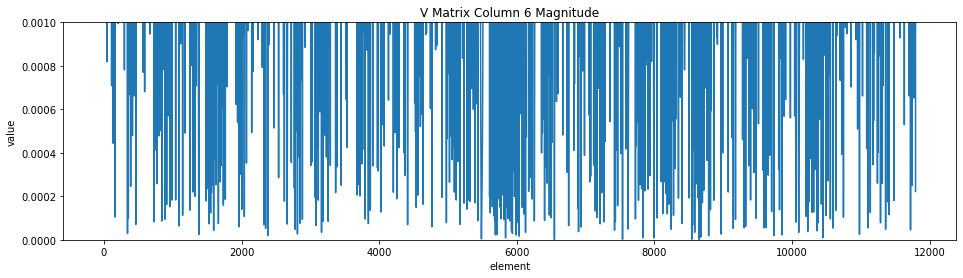

In [34]:
i=U.shape[0]-1
plt.figure(figsize=(16, 4))
plt.title('V Matrix Column '+str(i+1)+' Magnitude')
plt.plot(range(len(V[:,i])),np.abs(V[:,i]))
plt.xlabel('element')
plt.ylabel('value')
plt.ylim(0,0.001)
plt.show()

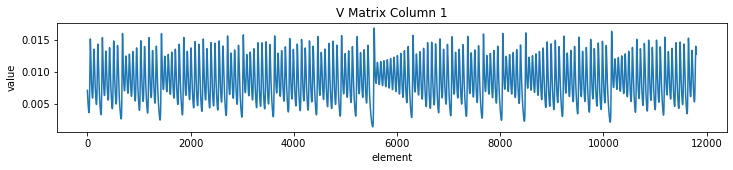

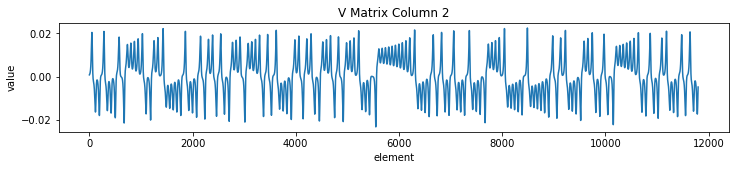

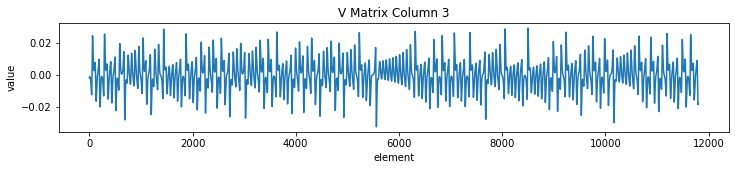

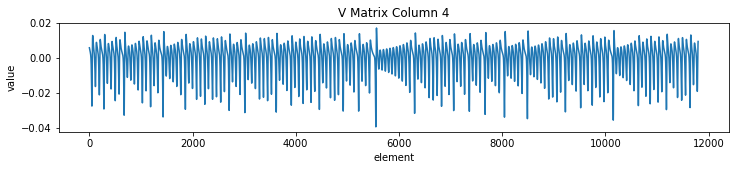

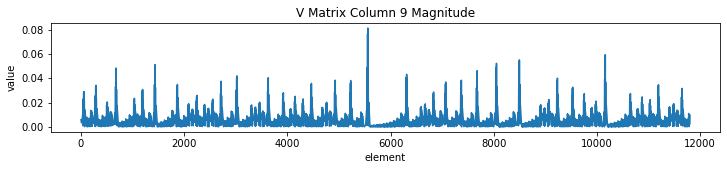

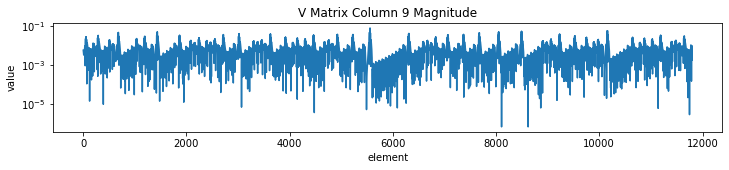

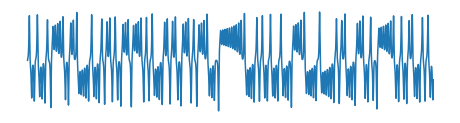

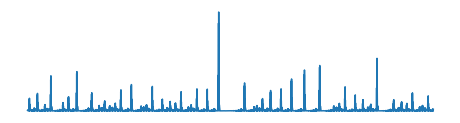

In [35]:
U,s,V,A,B=HAVOK(Sol,dt,3,get_lmodel=True)

for i in range(4):
    plt.figure(figsize=(12, 2))
    plt.title('V Matrix Column '+str(i+1))
    plt.plot(range(len(V[:,i])),V[:,i])
    plt.xlabel('element')
    plt.ylabel('value')
    plt.show()

i=U.shape[0]-1
plt.figure(figsize=(12, 2))
plt.title('V Matrix Column '+str(i+1)+' Magnitude')
plt.plot(range(len(V[:,i])),np.abs(V[:,i]))
plt.xlabel('element')
plt.ylabel('value')
plt.show()

i=U.shape[0]-1
plt.figure(figsize=(12, 2))
plt.title('V Matrix Column '+str(i+1)+' Magnitude')
plt.plot(range(len(V[:,i])),np.abs(V[:,i]))
plt.xlabel('element')
plt.ylabel('value')
plt.yscale('log')
plt.show()

plt.figure(figsize=(8,2))
plt.plot(tstamps,Sol[0])
plt.axis('off')
plt.show()

plt.figure(figsize=(8,2))
plt.plot(range(len(V[:,i])),np.abs(V[:,i])**2)
plt.axis('off')
plt.show()

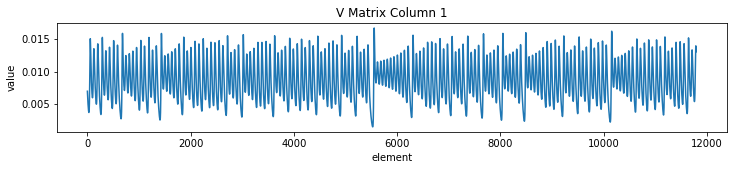

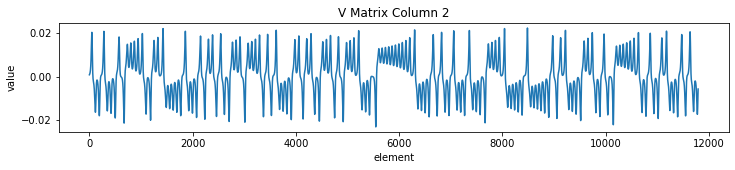

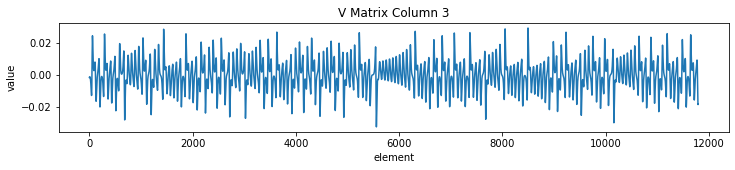

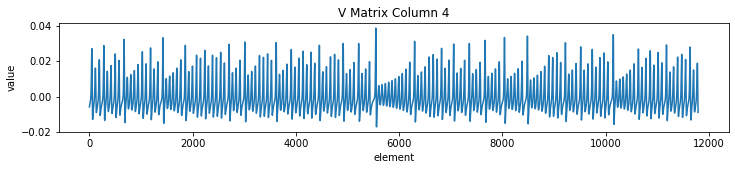

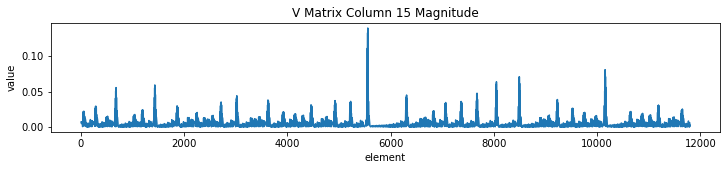

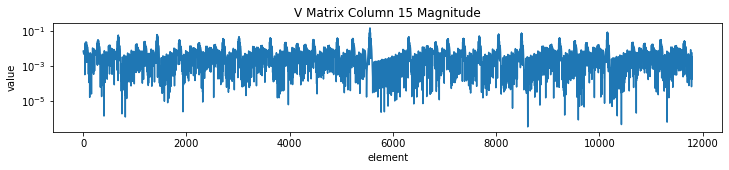

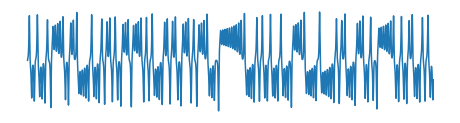

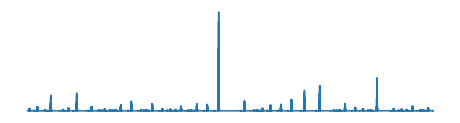

In [36]:
U,s,V,A,B=HAVOK(Sol,dt,5,get_lmodel=True)

for i in range(4):
    plt.figure(figsize=(12, 2))
    plt.title('V Matrix Column '+str(i+1))
    plt.plot(range(len(V[:,i])),V[:,i])
    plt.xlabel('element')
    plt.ylabel('value')
    plt.show()

i=U.shape[0]-1
plt.figure(figsize=(12, 2))
plt.title('V Matrix Column '+str(i+1)+' Magnitude')
plt.plot(range(len(V[:,i])),np.abs(V[:,i]))
plt.xlabel('element')
plt.ylabel('value')
plt.show()

i=U.shape[0]-1
plt.figure(figsize=(12, 2))
plt.title('V Matrix Column '+str(i+1)+' Magnitude')
plt.plot(range(len(V[:,i])),np.abs(V[:,i]))
plt.xlabel('element')
plt.ylabel('value')
plt.yscale('log')
plt.show()

plt.figure(figsize=(8,2))
plt.plot(tstamps,Sol[0])
plt.axis('off')
plt.show()

plt.figure(figsize=(8,2))
plt.plot(range(len(V[:,i])),np.abs(V[:,i])**2)
plt.axis('off')
plt.show()

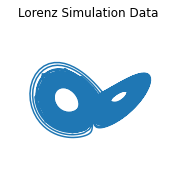

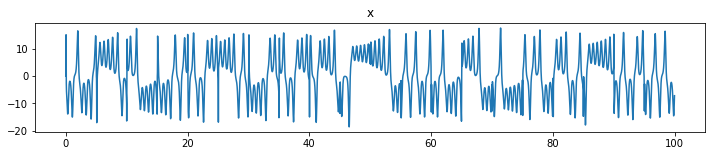

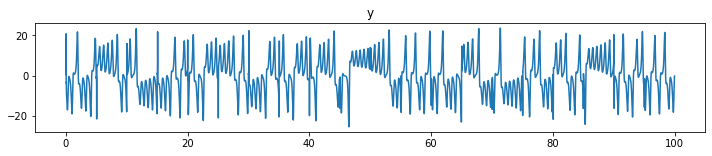

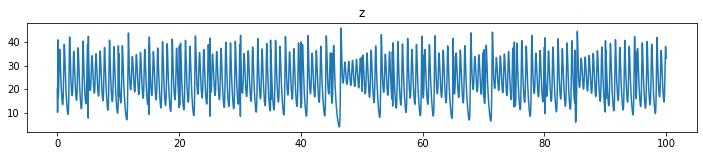

In [39]:
x0=[0,1,20]

dt=0.01
tstamps=np.arange(0,118,dt)

Sol=sc.integrate.odeint(lorenz,x0,tstamps,args=(),rtol=1e-12,atol=1e-12).T
Soldt=np.gradient(Sol.T[:,:],dt,axis=0).T

'''ind=np.arange(int(1/dt))
ind=np.delete(ind,np.arange(int(1/dt))[::10],0)
indt=np.copy(ind)
for i in range(20):
    indt=np.append(indt,i*600+ind)
    
Sol=np.delete(Sol.T,indt,0).T
tstamps=np.arange(0,100,dt)'''

at=10

ind=np.arange(500-at)+100
ind=np.append(np.arange(at)*10,ind)
indt=np.copy(ind)
for i in range(1,20):
    indt=np.append(indt,i*(600-at)+ind)
    
Sol=Sol.T[indt].T
tstamps=np.arange(0,100,dt)

plt.figure(figsize=(4,3))
ax=plt.axes(projection='3d')
ax.plot3D(Sol[0], Sol[1], Sol[2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.title('Lorenz Simulation Data')
plt.axis('off')
plt.show()

plt.figure(figsize=(12,2))
plt.title('x')
plt.plot(tstamps,Sol[0])
plt.show()

plt.figure(figsize=(12,2))
plt.title('y')
plt.plot(tstamps,Sol[1])
plt.show()

plt.figure(figsize=(12,2))
plt.title('z')
plt.plot(tstamps,Sol[2])
plt.show()

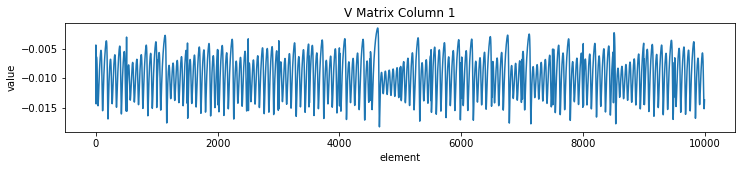

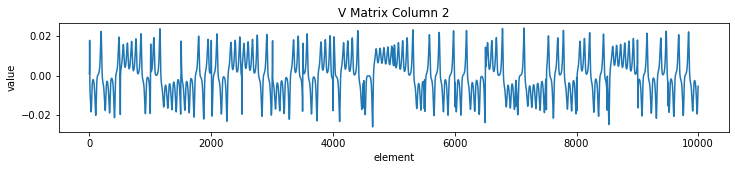

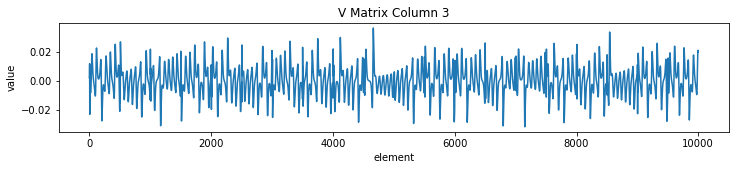

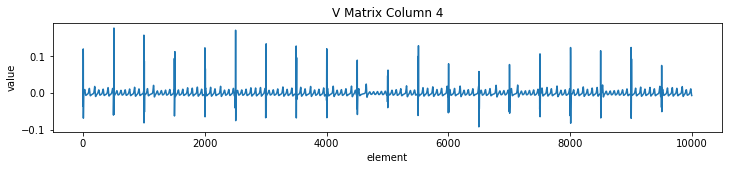

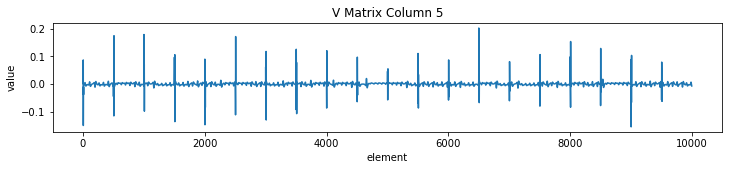

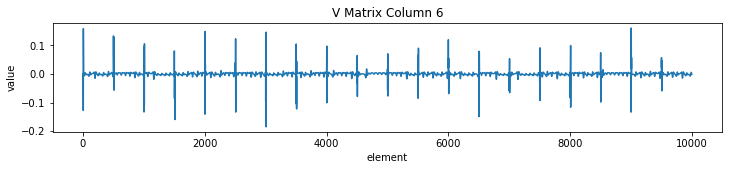

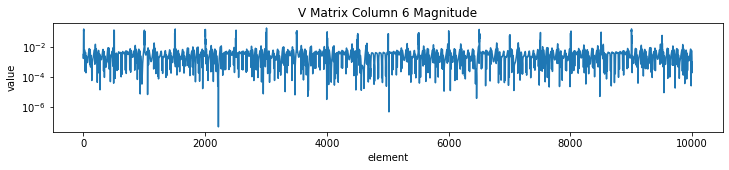

In [40]:
U,s,V,A,B=HAVOK(Sol,dt,2,get_lmodel=True)

for i in range(U.shape[0]):
    plt.figure(figsize=(12, 2))
    plt.title('V Matrix Column '+str(i+1))
    plt.plot(range(len(V[:,i])),V[:,i])
    plt.xlabel('element')
    plt.ylabel('value')
    plt.show()

i=U.shape[0]-1
plt.figure(figsize=(12, 2))
plt.title('V Matrix Column '+str(i+1)+' Magnitude')
plt.plot(range(len(V[:,i])),np.abs(V[:,i]))
plt.xlabel('element')
plt.ylabel('value')
plt.yscale('log')
plt.show()

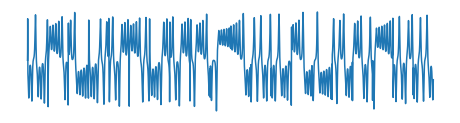

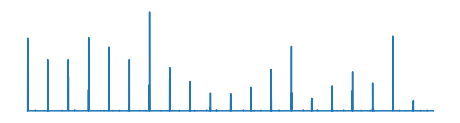

In [41]:
plt.figure(figsize=(8,2))
plt.plot(tstamps,Sol[0])
plt.axis('off')
plt.show()

plt.figure(figsize=(8,2))
plt.plot(range(len(V[:,i])),np.abs(V[:,i])**2)
plt.axis('off')
plt.show()

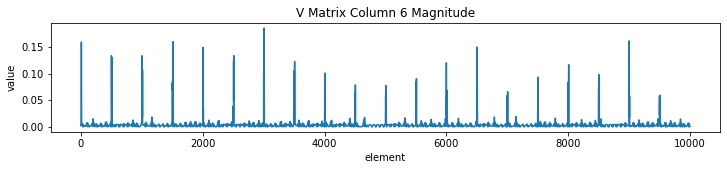

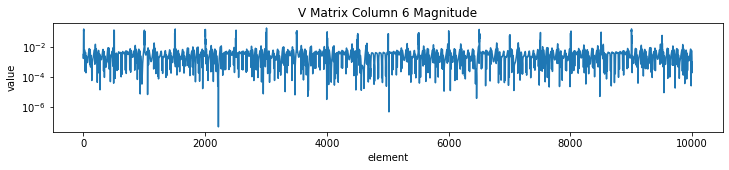

In [42]:
i=U.shape[0]-1
plt.figure(figsize=(12, 2))
plt.title('V Matrix Column '+str(i+1)+' Magnitude')
plt.plot(range(len(V[:,i])),np.abs(V[:,i]))
plt.xlabel('element')
plt.ylabel('value')
plt.show()

i=U.shape[0]-1
plt.figure(figsize=(12, 2))
plt.title('V Matrix Column '+str(i+1)+' Magnitude')
plt.plot(range(len(V[:,i])),np.abs(V[:,i]))
plt.xlabel('element')
plt.ylabel('value')
plt.yscale('log')
plt.show()

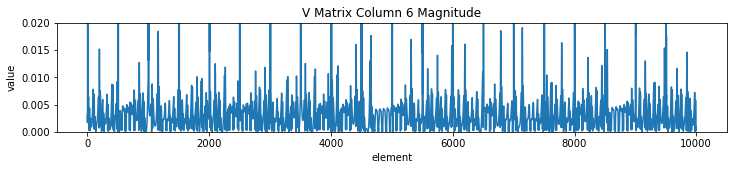

In [43]:
i=U.shape[0]-1
plt.figure(figsize=(12, 2))
plt.title('V Matrix Column '+str(i+1)+' Magnitude')
plt.plot(range(len(V[:,i])),np.abs(V[:,i]))
plt.xlabel('element')
plt.ylabel('value')
plt.ylim(0,0.02)
plt.show()

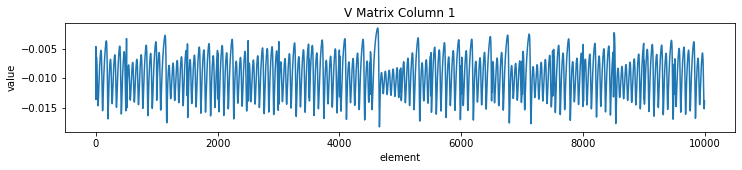

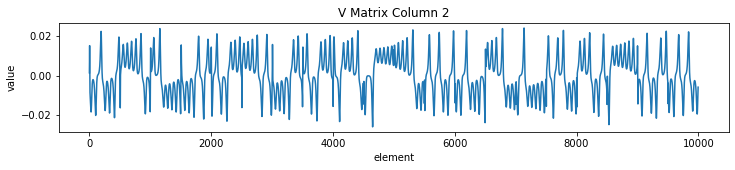

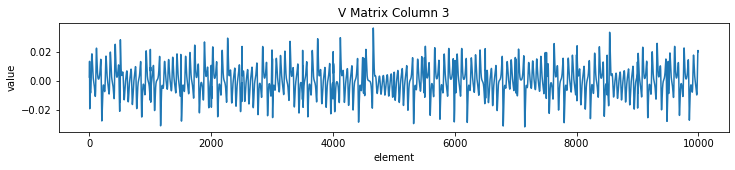

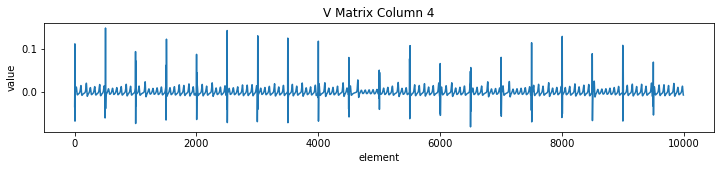

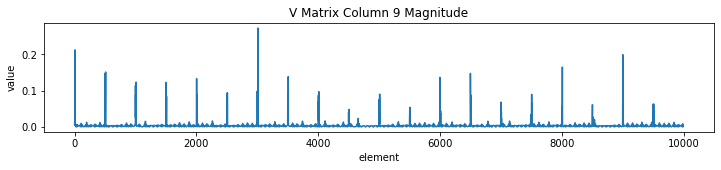

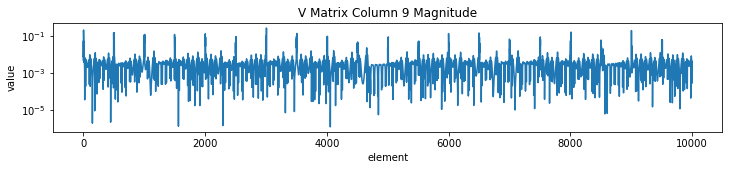

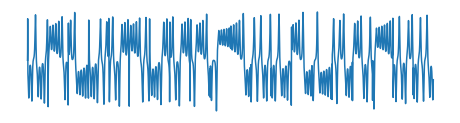

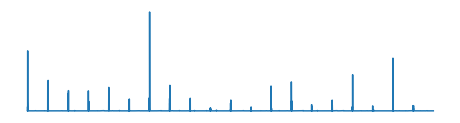

In [44]:
U,s,V,A,B=HAVOK(Sol,dt,3,get_lmodel=True)

for i in range(4):
    plt.figure(figsize=(12, 2))
    plt.title('V Matrix Column '+str(i+1))
    plt.plot(range(len(V[:,i])),V[:,i])
    plt.xlabel('element')
    plt.ylabel('value')
    plt.show()

i=U.shape[0]-1
plt.figure(figsize=(12, 2))
plt.title('V Matrix Column '+str(i+1)+' Magnitude')
plt.plot(range(len(V[:,i])),np.abs(V[:,i]))
plt.xlabel('element')
plt.ylabel('value')
plt.show()

i=U.shape[0]-1
plt.figure(figsize=(12, 2))
plt.title('V Matrix Column '+str(i+1)+' Magnitude')
plt.plot(range(len(V[:,i])),np.abs(V[:,i]))
plt.xlabel('element')
plt.ylabel('value')
plt.yscale('log')
plt.show()

plt.figure(figsize=(8,2))
plt.plot(tstamps,Sol[0])
plt.axis('off')
plt.show()

plt.figure(figsize=(8,2))
plt.plot(range(len(V[:,i])),np.abs(V[:,i])**2)
plt.axis('off')
plt.show()

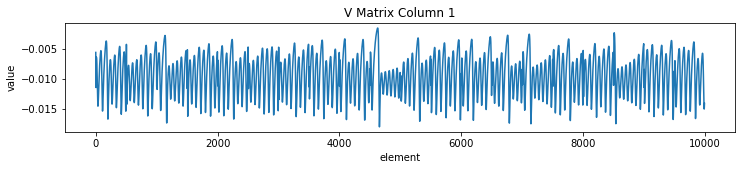

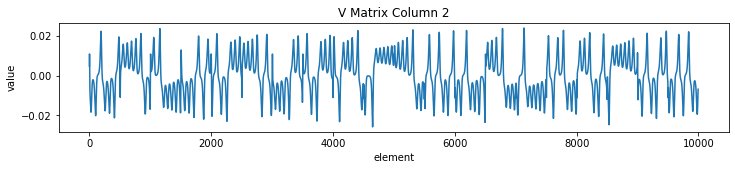

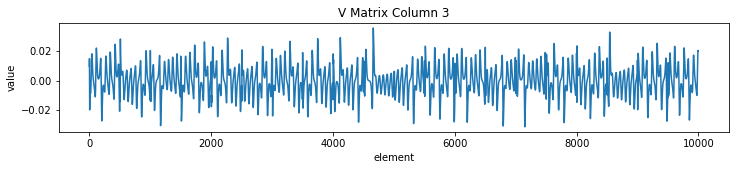

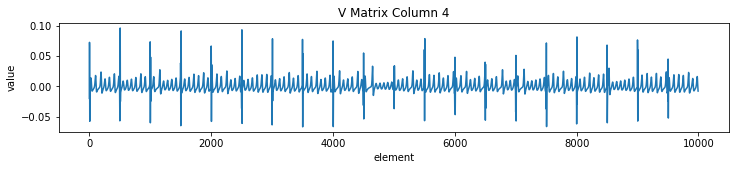

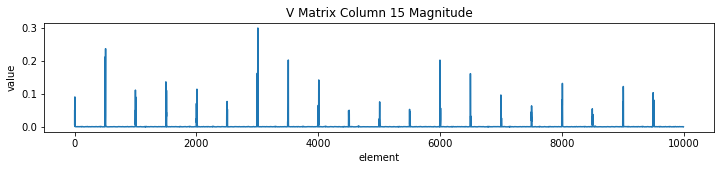

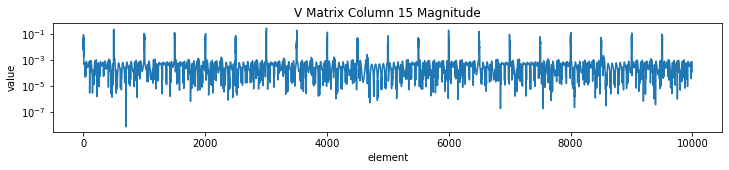

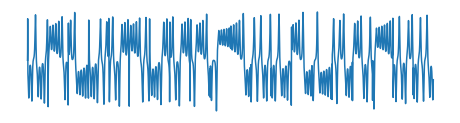

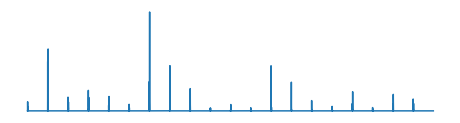

In [45]:
U,s,V,A,B=HAVOK(Sol,dt,5,get_lmodel=True)

for i in range(4):
    plt.figure(figsize=(12, 2))
    plt.title('V Matrix Column '+str(i+1))
    plt.plot(range(len(V[:,i])),V[:,i])
    plt.xlabel('element')
    plt.ylabel('value')
    plt.show()

i=U.shape[0]-1
plt.figure(figsize=(12, 2))
plt.title('V Matrix Column '+str(i+1)+' Magnitude')
plt.plot(range(len(V[:,i])),np.abs(V[:,i]))
plt.xlabel('element')
plt.ylabel('value')
plt.show()

i=U.shape[0]-1
plt.figure(figsize=(12, 2))
plt.title('V Matrix Column '+str(i+1)+' Magnitude')
plt.plot(range(len(V[:,i])),np.abs(V[:,i]))
plt.xlabel('element')
plt.ylabel('value')
plt.yscale('log')
plt.show()

plt.figure(figsize=(8,2))
plt.plot(tstamps,Sol[0])
plt.axis('off')
plt.show()

plt.figure(figsize=(8,2))
plt.plot(range(len(V[:,i])),np.abs(V[:,i])**2)
plt.axis('off')
plt.show()

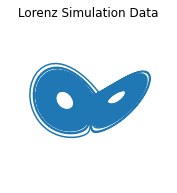

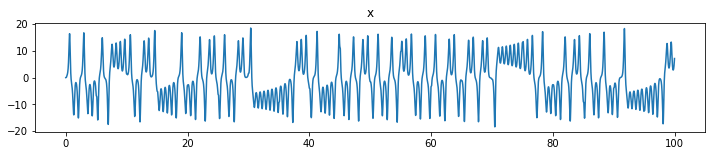

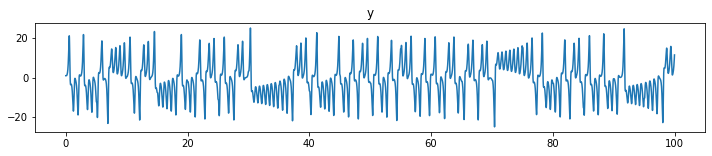

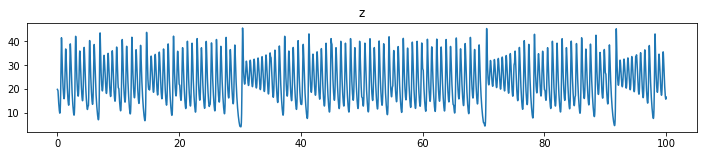

In [46]:
x0=[0,1,20]

dt=0.001
tstamps=np.arange(0,100,dt)

Sol=sc.integrate.odeint(lorenz,x0,tstamps,args=(),rtol=1e-12,atol=1e-12).T
Soldt=np.gradient(Sol.T[:,:],dt,axis=0).T

at=10

ind=np.arange(500-at)*10+at
ind=np.append(np.arange(at),ind)
indt=np.copy(ind)
for i in range(1,20):
    indt=np.append(indt,i*(10*(500-at)+1)+ind)
    
dt=0.01
Sol=Sol.T[indt].T
tstamps=np.arange(0,100,dt)

plt.figure(figsize=(4,3))
ax=plt.axes(projection='3d')
ax.plot3D(Sol[0], Sol[1], Sol[2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.title('Lorenz Simulation Data')
plt.axis('off')
plt.show()

plt.figure(figsize=(12,2))
plt.title('x')
plt.plot(tstamps,Sol[0])
plt.show()

plt.figure(figsize=(12,2))
plt.title('y')
plt.plot(tstamps,Sol[1])
plt.show()

plt.figure(figsize=(12,2))
plt.title('z')
plt.plot(tstamps,Sol[2])
plt.show()

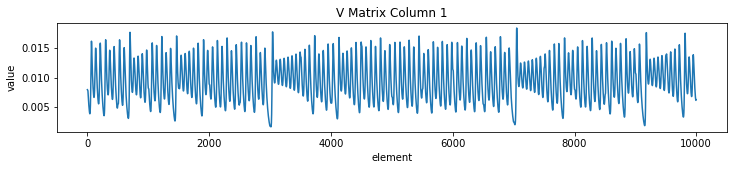

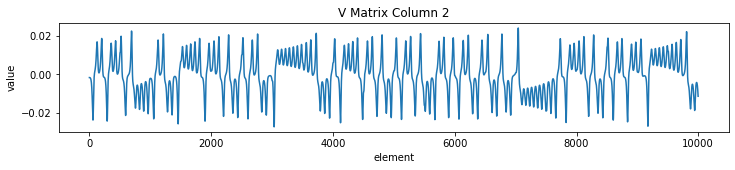

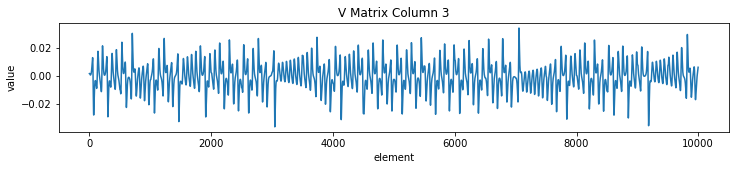

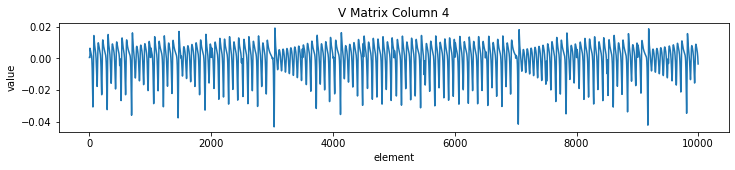

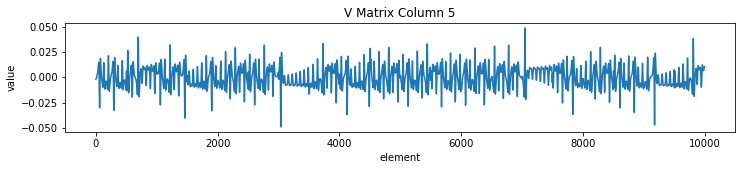

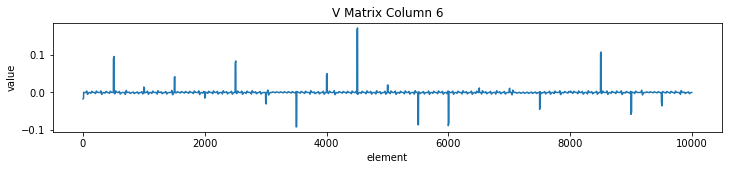

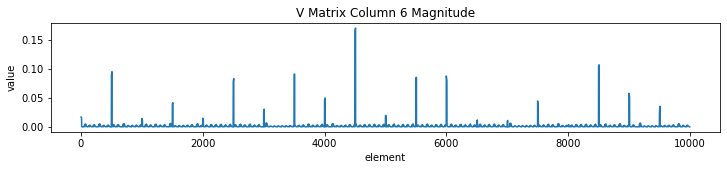

In [47]:
U,s,V,A,B=HAVOK(Sol,dt,2,get_lmodel=True)

for i in range(U.shape[0]):
    plt.figure(figsize=(12, 2))
    plt.title('V Matrix Column '+str(i+1))
    plt.plot(range(len(V[:,i])),V[:,i])
    plt.xlabel('element')
    plt.ylabel('value')
    plt.show()

i=U.shape[0]-1
plt.figure(figsize=(12, 2))
plt.title('V Matrix Column '+str(i+1)+' Magnitude')
plt.plot(range(len(V[:,i])),np.abs(V[:,i]))
plt.xlabel('element')
plt.ylabel('value')
plt.show()

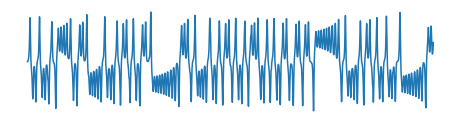

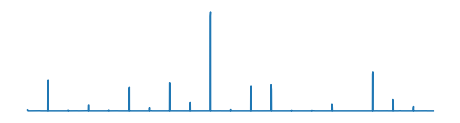

In [48]:
plt.figure(figsize=(8,2))
plt.plot(tstamps,Sol[0])
plt.axis('off')
plt.show()

plt.figure(figsize=(8,2))
plt.plot(range(len(V[:,i])),np.abs(V[:,i])**2)
plt.axis('off')
plt.show()

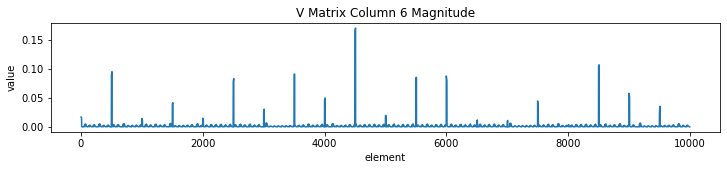

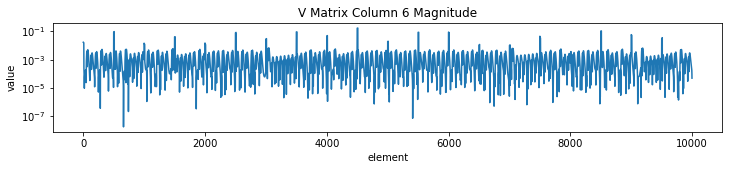

In [49]:
i=U.shape[0]-1
plt.figure(figsize=(12, 2))
plt.title('V Matrix Column '+str(i+1)+' Magnitude')
plt.plot(range(len(V[:,i])),np.abs(V[:,i]))
plt.xlabel('element')
plt.ylabel('value')
plt.show()

i=U.shape[0]-1
plt.figure(figsize=(12, 2))
plt.title('V Matrix Column '+str(i+1)+' Magnitude')
plt.plot(range(len(V[:,i])),np.abs(V[:,i]))
plt.xlabel('element')
plt.ylabel('value')
plt.yscale('log')
plt.show()

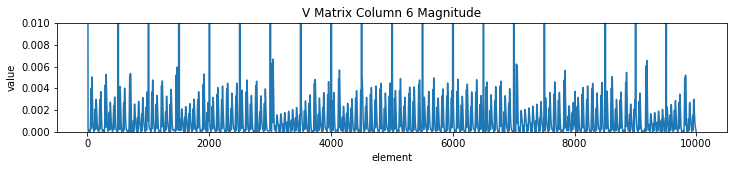

In [50]:
i=U.shape[0]-1
plt.figure(figsize=(12, 2))
plt.title('V Matrix Column '+str(i+1)+' Magnitude')
plt.plot(range(len(V[:,i])),np.abs(V[:,i]))
plt.xlabel('element')
plt.ylabel('value')
plt.ylim(0,0.01)
plt.show()

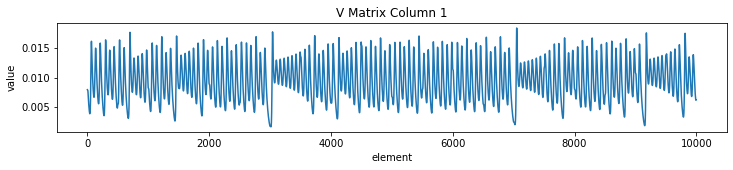

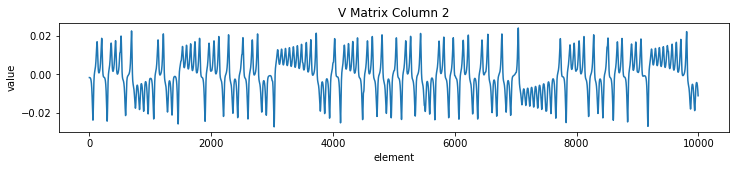

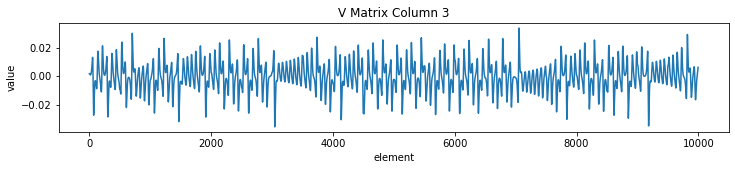

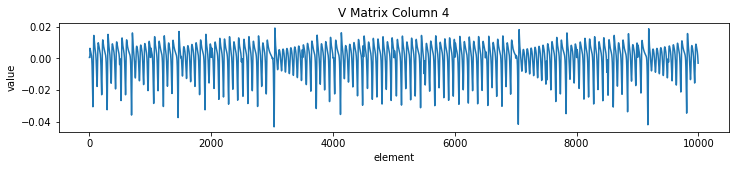

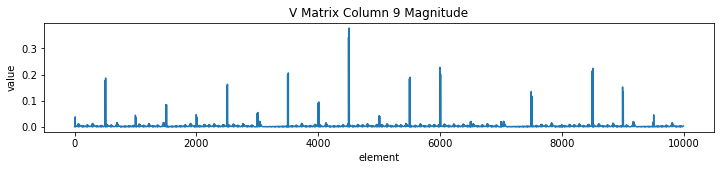

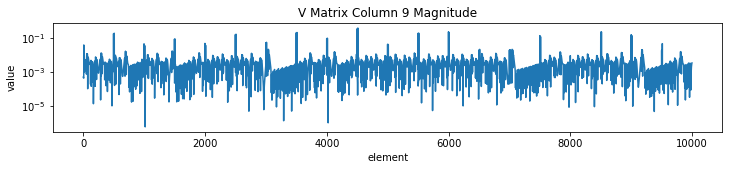

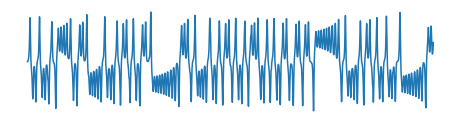

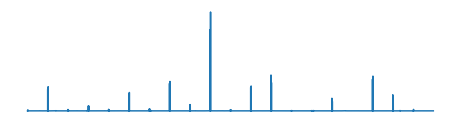

In [51]:
U,s,V,A,B=HAVOK(Sol,dt,3,get_lmodel=True)

for i in range(4):
    plt.figure(figsize=(12, 2))
    plt.title('V Matrix Column '+str(i+1))
    plt.plot(range(len(V[:,i])),V[:,i])
    plt.xlabel('element')
    plt.ylabel('value')
    plt.show()

i=U.shape[0]-1
plt.figure(figsize=(12, 2))
plt.title('V Matrix Column '+str(i+1)+' Magnitude')
plt.plot(range(len(V[:,i])),np.abs(V[:,i]))
plt.xlabel('element')
plt.ylabel('value')
plt.show()

i=U.shape[0]-1
plt.figure(figsize=(12, 2))
plt.title('V Matrix Column '+str(i+1)+' Magnitude')
plt.plot(range(len(V[:,i])),np.abs(V[:,i]))
plt.xlabel('element')
plt.ylabel('value')
plt.yscale('log')
plt.show()

plt.figure(figsize=(8,2))
plt.plot(tstamps,Sol[0])
plt.axis('off')
plt.show()

plt.figure(figsize=(8,2))
plt.plot(range(len(V[:,i])),np.abs(V[:,i])**2)
plt.axis('off')
plt.show()

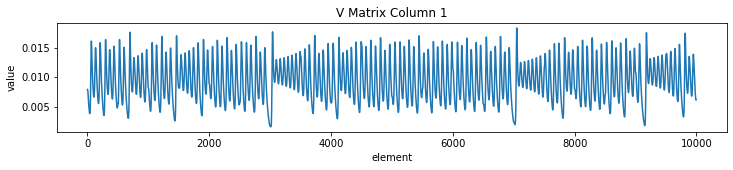

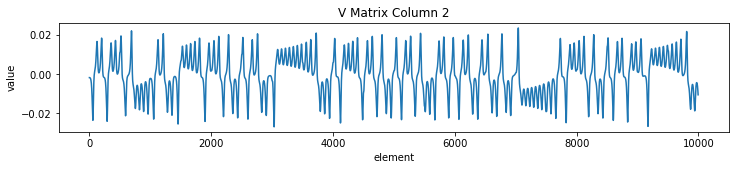

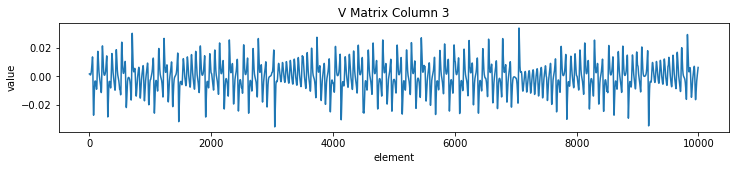

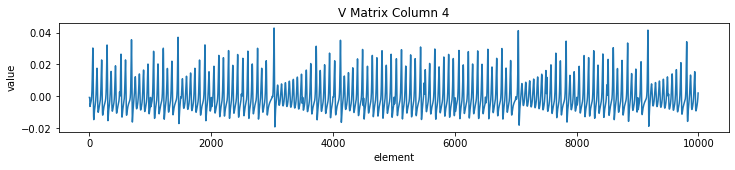

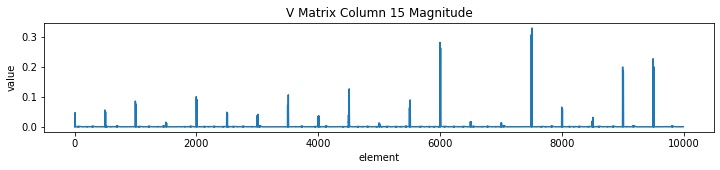

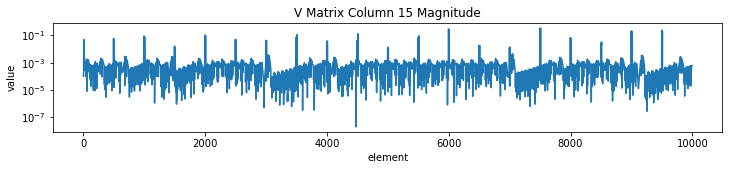

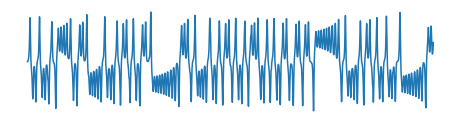

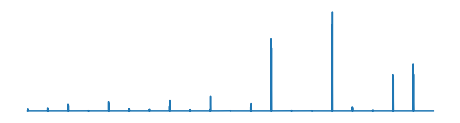

In [52]:
U,s,V,A,B=HAVOK(Sol,dt,5,get_lmodel=True)

for i in range(4):
    plt.figure(figsize=(12, 2))
    plt.title('V Matrix Column '+str(i+1))
    plt.plot(range(len(V[:,i])),V[:,i])
    plt.xlabel('element')
    plt.ylabel('value')
    plt.show()

i=U.shape[0]-1
plt.figure(figsize=(12, 2))
plt.title('V Matrix Column '+str(i+1)+' Magnitude')
plt.plot(range(len(V[:,i])),np.abs(V[:,i]))
plt.xlabel('element')
plt.ylabel('value')
plt.show()

i=U.shape[0]-1
plt.figure(figsize=(12, 2))
plt.title('V Matrix Column '+str(i+1)+' Magnitude')
plt.plot(range(len(V[:,i])),np.abs(V[:,i]))
plt.xlabel('element')
plt.ylabel('value')
plt.yscale('log')
plt.show()

plt.figure(figsize=(8,2))
plt.plot(tstamps,Sol[0])
plt.axis('off')
plt.show()

plt.figure(figsize=(8,2))
plt.plot(range(len(V[:,i])),np.abs(V[:,i])**2)
plt.axis('off')
plt.show()